In [1]:
import ggcnn.experiment as experiment
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from collections import defaultdict


def load_sa1_dataset():
    keys_SA1 = []
    features_SA1 = []
    labels = []
    keys_SA2 = []
    features_SA2 = []
    
    # Load SA1 Node Features
    with open('Data/2018-09-02-NSW-SA1Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA1.append(s[0])
            features_SA1.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y
#             labels.append(np.floor(float(s[-1]) / 10).astype(int))
            labels.append(float(s[-1]))
    
    
    # Load SA2 Node Features
    with open('Data/2018-08-28-NSW-SA2Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA2.append(s[0])
            features_SA2.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y

    labels = np.array(labels)
    features_SA1 = np.array(features_SA1).reshape((len(keys_SA1), -1))
    features_SA2 = np.array(features_SA2).reshape((len(keys_SA2), -1))
    
    # Load SA1 Link Features
    with open('Data/Geography/2018-09-01-NSW-Neighbouring_Suburbs_With_Bridges-Filtered.csv', 'r') as file:
        adj_mat_SA1 = np.zeros((len(keys_SA1), len(keys_SA1)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA1.index(s[1])
            adj_mat_SA1[a, b] = 1
            adj_mat_SA1[b, a] = 1
    

    # Load SA2 Link Features
    with open('Data/Geography/2018-09-01-SA2Neighbouring_Suburbs_With_Bridges-Filtered.csv', 'r') as file:
        adj_mat_SA2 = np.zeros((len(keys_SA2), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA2.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA2[a, b] = 1
            adj_mat_SA2[b, a] = 1
    
    
    # Load SA1, SA2 Links
    with open('Data/2018-09-02-SA1SA2Links.csv', 'r') as file:
        adj_mat_SA1SA2 = np.zeros((len(keys_SA1), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA1SA2[a, b] = 1
    
    adj_mat_SA2SA1 = np.transpose(adj_mat_SA1SA2)
    
    return (features_SA1, adj_mat_SA1, labels, features_SA2, adj_mat_SA2, adj_mat_SA1SA2, adj_mat_SA2SA1), (keys_SA1, keys_SA2)

dataset, keys = load_sa1_dataset()

In [2]:
class SA1Experiment():
    def __init__(self, neurons, blocks, reverseLinkagePosition = "Early", linkagePosition = "Late",
                    linkageActFun = True, linkageBatchNorm = True, linkageNeurons = None,
                    auxilaryEmbedding1 = False, auxilaryEmbedding2 = False,
                    auxilaryGraph = False, linkage_adjustment_components = None):
        self.blocks = blocks
        self.neurons = neurons
        self.reverseLinkagePosition = reverseLinkagePosition
        self.linkagePosition = linkagePosition
        self.linkageActFun = linkageActFun
        self.linkageBatchNorm = linkageBatchNorm
        self.linkageNeurons = linkageNeurons
        self.auxilaryEmbedding1 = auxilaryEmbedding1
        self.auxilaryEmbedding2 = auxilaryEmbedding2
        self.auxilaryGraph = auxilaryGraph
        self.linkage_adjustment_components = linkage_adjustment_components
    
    def create_network(self, net, input):
        net.create_network(input)

        if self.linkage_adjustment_components is not None:
            net.make_linkage_adjustment_layer()
        
        if self.reverseLinkagePosition == "Early" or self.reverseLinkagePosition == "Both":
            net.make_reverse_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        if self.linkagePosition == "Early" or self.linkagePosition == "Both":
            net.make_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        
        net.make_embedding_layer(self.neurons)
        net.make_dropout_layer()
        
        for _ in range(self.blocks):
            net.make_graphcnn_layer(self.neurons)
            net.make_dropout_layer()
            net.make_embedding_layer(self.neurons)
            net.make_dropout_layer()
        
        if self.auxilaryEmbedding1:
            net.make_auxilary_embedding_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.reverseLinkagePosition == "Late" or self.reverseLinkagePosition == "Both":
            net.make_reverse_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        if self.auxilaryEmbedding2:
            net.make_auxilary_embedding_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.auxilaryGraph:
            net.make_auxilary_graphcnn_layer(self.neurons)
            net.make_dropout_layer(input_type = 'current_V_auxilary')
        if self.linkagePosition == "Late" or self.linkagePosition == "Both":
            net.make_auxilary_linkage_layer(self.linkageNeurons, with_act_func = self.linkageActFun, with_bn = self.linkageBatchNorm)
        
        net.make_embedding_layer(self.neurons)
        net.make_embedding_layer(1, name='final', with_bn=False, with_act_func = False)


######

def run(no_folds = 5, supervised = True, i = 0, l = 2, n = 128, expParameters = {}):
    inst = KFold(n_splits = no_folds, shuffle=True, random_state=125)
        
    exp = experiment.GGCNNExperiment('2018-08-28-SA1SA2', '2018-08-28-SA1SA2', SA1Experiment(neurons = n, blocks = l, **expParameters))

    exp.num_iterations = 5000
    exp.optimizer = 'adam'
    exp.loss_type = 'linear'

    exp.debug = True  # Was True

    exp.preprocess_data(dataset)

    valid_idx = np.flatnonzero(dataset[2] >= 0)  # Missing data labelled with -1
    if supervised:
        train_idx, test_idx = list(inst.split( valid_idx ))[i]
    else:
        test_idx, train_idx = list(inst.split( valid_idx ))[i]  # Reversed to get more samples in the test set than the training set

    n_components = expParameters.get('linkage_adjustment_components', None)
    exp.create_data(train_idx, test_idx, n_components = n_components)
    exp.build_network()
    results = exp.run()
    
    # Node type of input nodes: 0 = training set; 1 = test set; -1 = neither
    idx_split = np.empty((len(dataset[2]), 1))
    idx_split.fill(-1)
    idx_split[train_idx] = 0
    idx_split[test_idx] = 1

    return results, idx_split

In [3]:
expParameters = {"reverseLinkagePosition": "Early", "linkagePosition": "Late", "linkageActFun": False, "linkageBatchNorm": True,
                 "linkageNeurons": None, "auxilaryEmbedding1": False, "auxilaryEmbedding2": False, "auxilaryGraph": True,
                 "linkage_adjustment_components": 3}

results, idx_split = run(supervised = False, expParameters = expParameters)

2018-09-02 22:40:14.344590 Creating training Tensorflow Tensors
PCA variance ratio:  [0.17138442 0.12530963 0.08620865]
2018-09-02 22:40:15.399994 Creating training network
2018-09-02 22:40:16.032917 Creating loss function and summaries
2018-09-02 22:40:16.064039 Training model "2018-08-28-SA1SA2"!
2018-09-02 22:40:16.064098 Preparing training
2018-09-02 22:40:19.418936 Starting threads
2018-09-02 22:40:19.419568 Starting training. train_batch_size: 0 test_batch_size: 0
2018-09-02 22:40:22.342929 Test Step 0 Finished
2018-09-02 22:40:22.343017 Test Step 0 "min loss" =  9.735105e+16
2018-09-02 22:40:22.343062 Test Step 0 "loss" =  9.735105e+16
2018-09-02 22:40:27.006720 Training Step 0 Finished Timing (Training: 0.614677, Test: 0.385299) after 7.58708 seconds
2018-09-02 22:40:27.006834 Training Step 0 "min loss" =  2555.4531
2018-09-02 22:40:27.006883 Training Step 0 "loss" =  2555.4531
2018-09-02 22:40:38.281351 Test Step 5 Finished
2018-09-02 22:40:38.281438 Test Step 5 "min loss" =  

2018-09-02 22:44:59.987267 Training Step 90 Finished Timing (Training: 0.91938, Test: 0.0805845) after 15.9728 seconds
2018-09-02 22:44:59.987367 Training Step 90 "min loss" =  1778.7964
2018-09-02 22:44:59.987417 Training Step 90 "loss" =  1778.7964
2018-09-02 22:45:12.236280 Test Step 95 Finished
2018-09-02 22:45:12.236370 Test Step 95 "min loss" =  1682.3273
2018-09-02 22:45:12.236406 Test Step 95 "loss" =  1682.3273
2018-09-02 22:45:14.969905 Training Step 95 Finished Timing (Training: 0.919571, Test: 0.0803935) after 14.9824 seconds
2018-09-02 22:45:14.970003 Training Step 95 "min loss" =  1739.9954
2018-09-02 22:45:14.970052 Training Step 95 "loss" =  1739.9954
2018-09-02 22:45:27.454303 Test Step 100 Finished
2018-09-02 22:45:27.454396 Test Step 100 "min loss" =  1654.0144
2018-09-02 22:45:27.454703 Test Step 100 "loss" =  1654.0144
2018-09-02 22:45:30.236512 Training Step 100 Finished Timing (Training: 0.919757, Test: 0.0802073) after 15.2664 seconds
2018-09-02 22:45:30.236650 

2018-09-02 22:50:03.006219 Test Step 190 Finished
2018-09-02 22:50:03.006324 Test Step 190 "min loss" =  1010.6406
2018-09-02 22:50:03.006673 Test Step 190 "loss" =  1010.6406
2018-09-02 22:50:06.104165 Training Step 190 Finished Timing (Training: 0.919074, Test: 0.0808906) after 15.4103 seconds
2018-09-02 22:50:06.104265 Training Step 190 "min loss" =  986.927
2018-09-02 22:50:06.104314 Training Step 190 "loss" =  986.927
2018-09-02 22:50:18.912268 Test Step 195 Finished
2018-09-02 22:50:18.912364 Test Step 195 "min loss" =  964.19586
2018-09-02 22:50:18.912413 Test Step 195 "loss" =  964.19586
2018-09-02 22:50:22.004059 Training Step 195 Finished Timing (Training: 0.919046, Test: 0.080919) after 15.8997 seconds
2018-09-02 22:50:22.004165 Training Step 195 "min loss" =  948.68335
2018-09-02 22:50:22.004217 Training Step 195 "loss" =  948.68335
2018-09-02 22:50:34.386978 Test Step 200 Finished
2018-09-02 22:50:34.387079 Test Step 200 "min loss" =  926.84247
2018-09-02 22:50:34.387126 T

2018-09-02 22:54:57.931382 Training Step 285 Finished Timing (Training: 0.920725, Test: 0.0792387) after 15.4203 seconds
2018-09-02 22:54:57.931482 Training Step 285 "min loss" =  404.51752
2018-09-02 22:54:57.931529 Training Step 285 "loss" =  404.51752
2018-09-02 22:55:10.469210 Test Step 290 Finished
2018-09-02 22:55:10.469301 Test Step 290 "min loss" =  449.603
2018-09-02 22:55:10.469340 Test Step 290 "loss" =  449.603
2018-09-02 22:55:13.336440 Training Step 290 Finished Timing (Training: 0.92097, Test: 0.0789944) after 15.4049 seconds
2018-09-02 22:55:13.336563 Training Step 290 "min loss" =  384.43152
2018-09-02 22:55:13.336631 Training Step 290 "loss" =  384.43152
2018-09-02 22:55:24.949121 Test Step 295 Finished
2018-09-02 22:55:24.949234 Test Step 295 "min loss" =  418.16928
2018-09-02 22:55:24.949294 Test Step 295 "loss" =  418.16928
2018-09-02 22:55:27.858229 Training Step 295 Finished Timing (Training: 0.920953, Test: 0.0790115) after 14.5215 seconds
2018-09-02 22:55:27.85

2018-09-02 23:00:21.314653 Test Step 385 Finished
2018-09-02 23:00:21.314751 Test Step 385 "min loss" =  187.73625
2018-09-02 23:00:21.314800 Test Step 385 "loss" =  187.73625
2018-09-02 23:00:23.866914 Training Step 385 Finished Timing (Training: 0.919478, Test: 0.0804894) after 14.7146 seconds
2018-09-02 23:00:23.867016 Training Step 385 "min loss" =  121.51582
2018-09-02 23:00:23.867070 Training Step 385 "loss" =  121.51582
2018-09-02 23:00:36.844279 Test Step 390 Finished
2018-09-02 23:00:36.844372 Test Step 390 "min loss" =  178.87193
2018-09-02 23:00:36.844414 Test Step 390 "loss" =  178.87193
2018-09-02 23:00:39.474530 Training Step 390 Finished Timing (Training: 0.919888, Test: 0.0800798) after 15.6074 seconds
2018-09-02 23:00:39.474637 Training Step 390 "min loss" =  113.32627
2018-09-02 23:00:39.474688 Training Step 390 "loss" =  113.32627
2018-09-02 23:00:52.145998 Test Step 395 Finished
2018-09-02 23:00:52.146104 Test Step 395 "min loss" =  173.8463
2018-09-02 23:00:52.1461

2018-09-02 23:05:17.953922 Training Step 480 Finished Timing (Training: 0.918446, Test: 0.0815204) after 15.5766 seconds
2018-09-02 23:05:17.954021 Training Step 480 "min loss" =  55.68774
2018-09-02 23:05:17.954067 Training Step 480 "loss" =  58.348495
2018-09-02 23:05:30.863751 Test Step 485 Finished
2018-09-02 23:05:30.863853 Test Step 485 "min loss" =  123.83815
2018-09-02 23:05:30.863898 Test Step 485 "loss" =  123.83815
2018-09-02 23:05:33.505808 Training Step 485 Finished Timing (Training: 0.918297, Test: 0.0816702) after 15.5517 seconds
2018-09-02 23:05:33.505910 Training Step 485 "min loss" =  54.51204
2018-09-02 23:05:33.505964 Training Step 485 "loss" =  55.092983
2018-09-02 23:05:45.719166 Test Step 490 Finished
2018-09-02 23:05:45.719313 Test Step 490 "min loss" =  123.83815
2018-09-02 23:05:45.719397 Test Step 490 "loss" =  124.00079
2018-09-02 23:05:48.462806 Training Step 490 Finished Timing (Training: 0.918052, Test: 0.0819145) after 14.9568 seconds
2018-09-02 23:05:48

2018-09-02 23:10:24.684005 Test Step 580 Finished
2018-09-02 23:10:24.684102 Test Step 580 "min loss" =  116.582504
2018-09-02 23:10:24.684150 Test Step 580 "loss" =  118.529724
2018-09-02 23:10:27.576661 Training Step 580 Finished Timing (Training: 0.920665, Test: 0.0793001) after 16.6876 seconds
2018-09-02 23:10:27.576747 Training Step 580 "min loss" =  38.82612
2018-09-02 23:10:27.576784 Training Step 580 "loss" =  39.475433
2018-09-02 23:10:41.682584 Test Step 585 Finished
2018-09-02 23:10:41.682700 Test Step 585 "min loss" =  116.5423
2018-09-02 23:10:41.683082 Test Step 585 "loss" =  116.5423
2018-09-02 23:10:45.154315 Training Step 585 Finished Timing (Training: 0.920375, Test: 0.0795893) after 17.5775 seconds
2018-09-02 23:10:45.154423 Training Step 585 "min loss" =  38.82612
2018-09-02 23:10:45.154479 Training Step 585 "loss" =  39.94512
2018-09-02 23:10:59.716179 Test Step 590 Finished
2018-09-02 23:10:59.716284 Test Step 590 "min loss" =  116.5423
2018-09-02 23:10:59.716337 

2018-09-02 23:15:50.948857 Training Step 675 Finished Timing (Training: 0.920084, Test: 0.0798821) after 16.4063 seconds
2018-09-02 23:15:50.948962 Training Step 675 "min loss" =  30.113562
2018-09-02 23:15:50.949014 Training Step 675 "loss" =  32.404984
2018-09-02 23:16:02.746065 Test Step 680 Finished
2018-09-02 23:16:02.746168 Test Step 680 "min loss" =  112.73076
2018-09-02 23:16:02.746213 Test Step 680 "loss" =  114.44567
2018-09-02 23:16:05.448060 Training Step 680 Finished Timing (Training: 0.920231, Test: 0.0797352) after 14.499 seconds
2018-09-02 23:16:05.448160 Training Step 680 "min loss" =  30.113562
2018-09-02 23:16:05.448208 Training Step 680 "loss" =  33.373596
2018-09-02 23:16:17.939214 Test Step 685 Finished
2018-09-02 23:16:17.939305 Test Step 685 "min loss" =  112.73076
2018-09-02 23:16:17.939341 Test Step 685 "loss" =  114.30729
2018-09-02 23:16:20.608910 Training Step 685 Finished Timing (Training: 0.920331, Test: 0.0796353) after 15.1607 seconds
2018-09-02 23:16:2

2018-09-02 23:21:04.364935 Test Step 775 Finished
2018-09-02 23:21:04.365031 Test Step 775 "min loss" =  111.99585
2018-09-02 23:21:04.365068 Test Step 775 "loss" =  114.90948
2018-09-02 23:21:07.219769 Training Step 775 Finished Timing (Training: 0.91836, Test: 0.0816088) after 16.6272 seconds
2018-09-02 23:21:07.219863 Training Step 775 "min loss" =  23.733143
2018-09-02 23:21:07.220159 Training Step 775 "loss" =  30.023067
2018-09-02 23:21:20.948910 Test Step 780 Finished
2018-09-02 23:21:20.949007 Test Step 780 "min loss" =  111.99585
2018-09-02 23:21:20.949052 Test Step 780 "loss" =  113.772575
2018-09-02 23:21:23.840520 Training Step 780 Finished Timing (Training: 0.91827, Test: 0.0816977) after 16.6203 seconds
2018-09-02 23:21:23.840639 Training Step 780 "min loss" =  23.733143
2018-09-02 23:21:23.840706 Training Step 780 "loss" =  30.436132
2018-09-02 23:21:37.505288 Test Step 785 Finished
2018-09-02 23:21:37.505412 Test Step 785 "min loss" =  111.99585
2018-09-02 23:21:37.5054

2018-09-02 23:26:22.162682 Training Step 870 Finished Timing (Training: 0.919406, Test: 0.0805618) after 17.388 seconds
2018-09-02 23:26:22.162774 Training Step 870 "min loss" =  22.487627
2018-09-02 23:26:22.162817 Training Step 870 "loss" =  23.51291
2018-09-02 23:26:35.375889 Test Step 875 Finished
2018-09-02 23:26:35.375984 Test Step 875 "min loss" =  111.98518
2018-09-02 23:26:35.376022 Test Step 875 "loss" =  112.96143
2018-09-02 23:26:38.198063 Training Step 875 Finished Timing (Training: 0.919546, Test: 0.0804216) after 16.0352 seconds
2018-09-02 23:26:38.198163 Training Step 875 "min loss" =  21.726503
2018-09-02 23:26:38.198215 Training Step 875 "loss" =  27.526083
2018-09-02 23:26:52.562234 Test Step 880 Finished
2018-09-02 23:26:52.562542 Test Step 880 "min loss" =  111.98518
2018-09-02 23:26:52.562633 Test Step 880 "loss" =  114.31242
2018-09-02 23:26:55.986219 Training Step 880 Finished Timing (Training: 0.92006, Test: 0.079907) after 17.7879 seconds
2018-09-02 23:26:55.9

2018-09-02 23:31:44.541279 Test Step 970 Finished
2018-09-02 23:31:44.541367 Test Step 970 "min loss" =  111.89674
2018-09-02 23:31:44.541405 Test Step 970 "loss" =  113.54352
2018-09-02 23:31:47.689611 Training Step 970 Finished Timing (Training: 0.922997, Test: 0.0769662) after 16.717 seconds
2018-09-02 23:31:47.689872 Training Step 970 "min loss" =  20.1563
2018-09-02 23:31:47.689916 Training Step 970 "loss" =  22.64193
2018-09-02 23:32:00.688534 Test Step 975 Finished
2018-09-02 23:32:00.688632 Test Step 975 "min loss" =  111.89674
2018-09-02 23:32:00.688681 Test Step 975 "loss" =  112.33209
2018-09-02 23:32:03.774831 Training Step 975 Finished Timing (Training: 0.922985, Test: 0.076978) after 16.0849 seconds
2018-09-02 23:32:03.774921 Training Step 975 "min loss" =  20.1563
2018-09-02 23:32:03.774966 Training Step 975 "loss" =  23.955683
2018-09-02 23:32:16.681731 Test Step 980 Finished
2018-09-02 23:32:16.681818 Test Step 980 "min loss" =  111.89674
2018-09-02 23:32:16.681860 Tes

2018-09-02 23:36:47.760231 Test Step 1065 Finished
2018-09-02 23:36:47.760325 Test Step 1065 "min loss" =  111.89674
2018-09-02 23:36:47.760617 Test Step 1065 "loss" =  113.51517
2018-09-02 23:36:50.736621 Training Step 1065 Finished Timing (Training: 0.917484, Test: 0.0824794) after 16.7738 seconds
2018-09-02 23:36:50.736951 Training Step 1065 "min loss" =  18.523376
2018-09-02 23:36:50.737038 Training Step 1065 "loss" =  20.742077
2018-09-02 23:37:04.260971 Test Step 1070 Finished
2018-09-02 23:37:04.261080 Test Step 1070 "min loss" =  111.89674
2018-09-02 23:37:04.261392 Test Step 1070 "loss" =  114.43892
2018-09-02 23:37:07.269660 Training Step 1070 Finished Timing (Training: 0.917419, Test: 0.0825425) after 16.5325 seconds
2018-09-02 23:37:07.269751 Training Step 1070 "min loss" =  18.523376
2018-09-02 23:37:07.269793 Training Step 1070 "loss" =  19.427544
2018-09-02 23:37:20.781202 Test Step 1075 Finished
2018-09-02 23:37:20.781620 Test Step 1075 "min loss" =  111.89674
2018-09-0

2018-09-02 23:41:41.787932 Test Step 1160 Finished
2018-09-02 23:41:41.788064 Test Step 1160 "min loss" =  111.89674
2018-09-02 23:41:41.788137 Test Step 1160 "loss" =  113.36212
2018-09-02 23:41:44.439708 Training Step 1160 Finished Timing (Training: 0.919082, Test: 0.0808872) after 15.5222 seconds
2018-09-02 23:41:44.439800 Training Step 1160 "min loss" =  16.5244
2018-09-02 23:41:44.439843 Training Step 1160 "loss" =  20.777351
2018-09-02 23:41:56.843752 Test Step 1165 Finished
2018-09-02 23:41:56.843846 Test Step 1165 "min loss" =  111.89674
2018-09-02 23:41:56.843886 Test Step 1165 "loss" =  114.10826
2018-09-02 23:41:59.594815 Training Step 1165 Finished Timing (Training: 0.918733, Test: 0.0812368) after 15.1549 seconds
2018-09-02 23:41:59.594915 Training Step 1165 "min loss" =  16.5244
2018-09-02 23:41:59.594960 Training Step 1165 "loss" =  17.104036
2018-09-02 23:42:12.148874 Test Step 1170 Finished
2018-09-02 23:42:12.148994 Test Step 1170 "min loss" =  111.89674
2018-09-02 23

2018-09-02 23:46:51.708333 Test Step 1255 Finished
2018-09-02 23:46:51.708628 Test Step 1255 "min loss" =  111.37962
2018-09-02 23:46:51.708673 Test Step 1255 "loss" =  111.99585
2018-09-02 23:46:54.583630 Training Step 1255 Finished Timing (Training: 0.91682, Test: 0.0831479) after 16.0416 seconds
2018-09-02 23:46:54.583720 Training Step 1255 "min loss" =  15.871497
2018-09-02 23:46:54.583762 Training Step 1255 "loss" =  19.111843
2018-09-02 23:47:07.404482 Test Step 1260 Finished
2018-09-02 23:47:07.404588 Test Step 1260 "min loss" =  111.37962
2018-09-02 23:47:07.404650 Test Step 1260 "loss" =  113.05188
2018-09-02 23:47:10.373363 Training Step 1260 Finished Timing (Training: 0.916486, Test: 0.0834822) after 15.7896 seconds
2018-09-02 23:47:10.373460 Training Step 1260 "min loss" =  15.871497
2018-09-02 23:47:10.373506 Training Step 1260 "loss" =  18.809568
2018-09-02 23:47:22.204406 Test Step 1265 Finished
2018-09-02 23:47:22.204501 Test Step 1265 "min loss" =  111.37962
2018-09-02

KeyboardInterrupt: 

In [14]:
train_df = pd.DataFrame(results[0])
test_df = pd.DataFrame(results[1])
test_df.set_index(test_df.index * 5, inplace = True)

In [ ]:
import matplotlib.pyplot as plt

train_df['accuracy'].plot()
test_df['accuracy'].plot()
plt.show()

In [ ]:
train_df['cross_entropy'].loc[10:].plot()
test_df['cross_entropy'].loc[10:].plot()

plt.show()

7.008738040924072


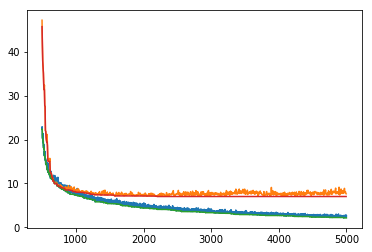

In [15]:
import matplotlib.pyplot as plt

train_df['loss'].loc[500:].plot()
test_df['loss'].loc[500:].plot()
train_df['min loss'].loc[500:].plot()
test_df['min loss'].loc[500:].plot()
print(test_df['min loss'].iloc[-1])

plt.show()

In [16]:
test_idx = np.flatnonzero(idx_split == 1)

predictions = results[-1].ravel()[test_idx]
actual = dataset[2].ravel()[test_idx]

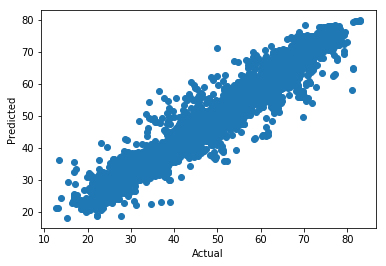

Max error:  23.091601316227496


In [17]:
plt.scatter(actual, predictions); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.show()
print('Max error: ', np.max(np.abs(actual - predictions)))

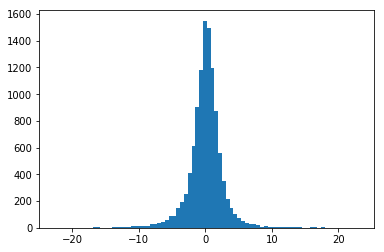

In [18]:
plt.hist(actual - predictions, bins = 80); plt.show()

In [19]:
import sklearn

sklearn.metrics.r2_score(predictions, actual)

0.9594218638137143

In [20]:
np.corrcoef(predictions, actual)

array([[1.     , 0.98213],
       [0.98213, 1.     ]])

In [12]:
### Save predictions
predictions_df = pd.DataFrame(np.hstack((results[-1], dataset[2].reshape((-1,1)), idx_split)), columns=['Prediction', 'Actual', 'idx_split'])
predictions_df.index = np.array(keys[0], dtype = int)
predictions_df.to_csv('PredictionsNoAuxilarySemisupervised.csv')

In [ ]:
predictions_df.head()